In [ ]:
import warnings
warnings.filterwarnings("ignore")

from pandas import json_normalize
import pandas as pd
from plotnine import ggplot, geom_col, coord_flip, aes, geom_line, theme, element_blank
from plotnine import geom_text, geom_point, labs, scale_y_continuous, theme_minimal
from mizani.formatters import comma_format
from sklearn.manifold import TSNE
import networkx as nx
import numpy as np
from karateclub import DeepWalk, Walklets, Role2Vec
from scipy.spatial.distance import cosine
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
import requests

# Graph Embeddings for Augmenting Domain Attribution
Authors: Ron Graf and Joe Mercado

### Section 1: Loading and Sampling Data
In this section we ingest our:
* MISP actors dataset
* OTX Pulse to MISP actors lookup dataset
* passive DNS dataset from OTX

In [2]:
misp_actor_url = "https://raw.githubusercontent.com/MISP/misp-galaxy/main/clusters/threat-actor.json"
misp_threat_actors = (json_normalize(
    requests.get(misp_actor_url).json()
    ["values"]).loc[:,["uuid", "value", "meta.cfr-suspected-state-sponsor"]])
misp_common_name_lookup = {}
for i,row in misp_threat_actors.iterrows():
    misp_common_name_lookup[row["uuid"]] = row["value"]

pulses_to_actor = pd.read_csv("https://gemada.s3.us-east-2.amazonaws.com/pulses_to_actor.csv")

pdns = pd.read_csv("https://gemada.s3.us-east-2.amazonaws.com/pdns_combined.csv")
pdns = (pdns[pdns["asset_type"]=="domain"].reset_index(drop=True))

host_to_actor_uuid = {}
for i, row in pdns.iterrows():
    host_to_actor_uuid[row["hostname"]] = row["actor_uuid"]

In [3]:
# we sample 55 domains which leaves us with 11 unique APT groups
sample_size = 55
domains_per_actor = (pdns.loc[:, ["hostname", "actor_uuid"]]
                       .drop_duplicates()["actor_uuid"]
                       .value_counts()
                       .to_frame("n")
                       .reset_index(drop=False)
                       .rename(columns={"index": "actor_uuid"})
                       .query("n > {}".format(sample_size))
                    )

domains_per_actor = pd.merge(domains_per_actor, misp_threat_actors, how="inner", left_on="actor_uuid", right_on="uuid")
domains_per_actor["label"] = domains_per_actor["value"] + " - " + domains_per_actor["meta.cfr-suspected-state-sponsor"]
domains_per_actor["label"] = domains_per_actor["label"].str.replace("\(.*", "", regex=True)
domains_per_actor["label"] = domains_per_actor["label"].str.replace("Korea", "DPRK")

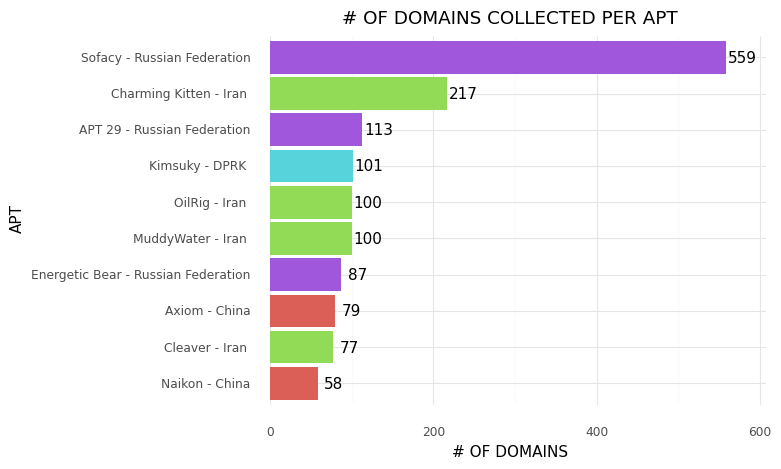

<ggplot: (8794362945720)>

In [4]:
# to give an idea of what our domains dataset looks like we plot # of domains
# per APT group, prior to sampling each actor down to 55 randomly selected domains
gg = (ggplot(domains_per_actor) +
      geom_col(aes(x="reorder(label, n)", y="n", fill="meta.cfr-suspected-state-sponsor"),
                  show_legend=False) +
      geom_text(aes(x="reorder(label, n)", y="n", label="n"), nudge_y=20) +
      coord_flip() +
      scale_y_continuous(expand = (0, 0, 0.05, 0)) +
      labs(y="# OF DOMAINS", x="APT", title="# OF DOMAINS COLLECTED PER APT") +
      theme_minimal()
     )
gg

In [5]:
# here we create our list of randomly sampled domains with an even 55 domains per each of the 11 APTs
sampled_domains = (pdns[pdns["actor_uuid"].isin(domains_per_actor["actor_uuid"].tolist())]
    .loc[:,["hostname", "actor_uuid"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .groupby("actor_uuid")
    .sample(n=sample_size)
    .reset_index(drop=True)
    )["hostname"].unique().tolist()
print("{:,} unique domains in sample".format(len(list(set(sampled_domains)))))
print("{:,} unique actors in sample".format(len(domains_per_actor["actor_uuid"].unique().tolist())))

# now we filter the pdns dataset for just the domains in our sample
sampled_pdns = pdns[pdns["hostname"].isin(sampled_domains).reset_index(drop=True)]
print("{:,} pDNS records in sample".format(len(sampled_pdns)))

550 unique domains in sample
10 unique actors in sample
4,768 pDNS records in sample


### Section 2: Graph Construction
In this section we create an undirected graph using networkx and add the following node and edge types from our pDNS dataframe:
* Nodes Types:
    * domain
    * nameserver
    * IPv4
    * ASN
    * country
* Edge Types:
    * domain-nameserver
    * domain-IPv4
    * IPv4-ASN
    * ASN-country

In [6]:
# create an undirected graph
G = nx.Graph()

# add domains
print("="*50)
print("adding domain nodes")
unique_hostnames = sampled_pdns["hostname"].unique().tolist()
G.add_nodes_from([(i, {"name": x, "type": "domain"}) for i,x in enumerate(unique_hostnames)])
print("{:,} nodes in graph".format(len(G.nodes())))

hostname_lookup = {}
for i,x in enumerate(unique_hostnames):
    hostname_lookup[x] = i
max_hostname_id = max([x for x in hostname_lookup.values()])    

rev_hostname_lookup = {}
for i,x in enumerate(unique_hostnames):
    rev_hostname_lookup[i] = x

# add nameservers
print("="*50)
print("adding nameservers")
unique_name_servers = sampled_pdns[sampled_pdns["record_type"]=="NS"]["address"].str.lower().unique().tolist()
G.add_nodes_from([(i + max_hostname_id, {"name": x, "type": "name_server"}) for i,x in enumerate(unique_name_servers)])
print("{:,} nodes in graph".format(len(G.nodes())))

ns_lookup = {}
for i,x in enumerate(unique_name_servers):
    ns_lookup[x] = i + max_hostname_id 
    
max_ns_id  = max([x for x in ns_lookup.values()])    
    
rev_ns_lookup = {}
for i,x in enumerate(unique_name_servers):
    rev_ns_lookup[i + max_hostname_id] = x

ns_to_domain = sampled_pdns[sampled_pdns["record_type"]=="NS"].loc[:, ["address", "hostname"]]
ns_to_domain["address"] = ns_to_domain["address"].str.lower()
ns_to_domain["hostname"] = ns_to_domain["hostname"].str.lower()
ns_to_domain = ns_to_domain.drop_duplicates().reset_index(drop=True)

ns_to_domain["ns_index"] = ns_to_domain["address"].apply(lambda x: ns_lookup[x])
ns_to_domain["hostname_index"] = ns_to_domain["hostname"].apply(lambda x: hostname_lookup[x])

edge_list = [(row["ns_index"], row["hostname_index"]) for i, row in ns_to_domain.iterrows()]

print("adding domain-nameservers edges")
G.add_edges_from(edge_list)
print("{:,} edges in graph".format(len(G.edges())))

# add ips
print("="*50)
print("adding ip nodes")
unique_ipv4 = sampled_pdns[sampled_pdns["record_type"]=="A"]["address"].str.lower().unique().tolist()
G.add_nodes_from([(i + max_ns_id, {"name": x, "type": "ipv4"}) for i,x in enumerate(unique_ipv4)])
print("{:,} nodes in graph".format(len(G.nodes())))

ipv4_lookup = {}
for i,x in enumerate(unique_ipv4):
    ipv4_lookup[x] = i + max_ns_id

rev_ipv4_lookup = {}
for i,x in enumerate(unique_ipv4):
    rev_ipv4_lookup[i + max_ns_id] = x

ipv4_to_domain = sampled_pdns[sampled_pdns["record_type"]=="A"].loc[:, ["address", "hostname"]]
ipv4_to_domain["address"] = ipv4_to_domain["address"].str.lower()
ipv4_to_domain["hostname"] = ipv4_to_domain["hostname"].str.lower()
ipv4_to_domain = ipv4_to_domain.drop_duplicates().reset_index(drop=True)

ipv4_to_domain["ipv4_index"] = ipv4_to_domain["address"].apply(lambda x: ipv4_lookup[x])
ipv4_to_domain["hostname_index"] = ipv4_to_domain["hostname"].apply(lambda x: hostname_lookup[x])

edge_list = [(row["ipv4_index"], row["hostname_index"]) for i, row in ipv4_to_domain.iterrows()]

print("adding ipv4-domain edges")
G.add_edges_from(edge_list)
print("{:,} edges in graph".format(len(G.edges())))

max_ipv4_id  = max([x for x in ipv4_lookup.values()])    

# add asns
print("="*50)
print("adding asn nodes")
sampled_pdns["asn"] = sampled_pdns["asn"].str.lower()
unique_asns = sampled_pdns[sampled_pdns["record_type"]=="A"]["asn"].unique().tolist()
G.add_nodes_from([(i + max_ipv4_id, {"name": x, "type": "asn"}) for i,x in enumerate(unique_asns)])
print("{:,} nodes in graph".format(len(G.nodes())))

asn_lookup = {}
for i,x in enumerate(unique_asns):
    asn_lookup[x] = i + max_ipv4_id

rev_asn_lookup = {}
for i,x in enumerate(unique_asns):
    rev_asn_lookup[i + max_ipv4_id] = x

ipv4_to_asn = sampled_pdns[sampled_pdns["record_type"]=="A"].loc[:, ["address", "asn"]]
ipv4_to_asn["address"] = ipv4_to_asn["address"].str.lower()
ipv4_to_asn = ipv4_to_asn.drop_duplicates().reset_index(drop=True)

ipv4_to_asn["ipv4_index"] = ipv4_to_asn["address"].apply(lambda x: ipv4_lookup[x])
ipv4_to_asn["asn_index"] = ipv4_to_asn["asn"].apply(lambda x: asn_lookup[x])

edge_list = [(row["ipv4_index"], row["asn_index"]) for i, row in ipv4_to_asn.iterrows()]
print("adding ipv4 to asn edges")
G.add_edges_from(edge_list)
print("{:,} edges in graph".format(len(G.edges())))

max_asn_id  = max([x for x in asn_lookup.values()])    

# add countries
print("="*50)
print("adding country nodes")
unique_flags = sampled_pdns[sampled_pdns["record_type"]=="A"].flag_title.unique()

G.add_nodes_from([(i + max_asn_id, {"name": x, "type": "flag"}) for i,x in enumerate(unique_flags)])
print("{:,} nodes in graph".format(len(G.nodes())))

flag_lookup = {}
for i,x in enumerate(unique_flags):
    flag_lookup[x] = i + max_asn_id

rev_flag_lookup = {}
for i,x in enumerate(unique_flags):
    rev_flag_lookup[i + max_asn_id] = x

asn_flag_lookup = sampled_pdns[sampled_pdns["record_type"]=="A"].loc[:, ["asn", "flag_title"]].drop_duplicates().reset_index(drop=True)
asn_flag_lookup["flag_index"] = asn_flag_lookup["flag_title"].apply(lambda x: flag_lookup[x])
asn_flag_lookup["asn_index"] = asn_flag_lookup["asn"].apply(lambda x: asn_lookup[x])

edge_list = [(row["flag_index"], row["asn_index"]) for i, row in asn_flag_lookup.iterrows()]
print("adding asn-country edges")
G.add_edges_from(edge_list)
print("{:,} edges in graph".format(len(G.edges())))

adding domain nodes
550 nodes in graph
adding nameservers
1,121 nodes in graph
adding domain-nameservers edges
1,555 edges in graph
adding ip nodes
2,415 nodes in graph
adding ipv4-domain edges
3,841 edges in graph
adding asn nodes
2,677 nodes in graph
adding ipv4 to asn edges
5,145 edges in graph
adding country nodes
2,730 nodes in graph
adding asn-country edges
5,483 edges in graph


### Section 3: Performance Evaluation
In this section we: 
* fit graph embeddings on the graph from the previous section using DeepWalk, Walklets, and Role2Vec
* calculate cosine similarity between all pairwise combinations of domains in our sample
* plot 2D tSNE representations of all the domains embedding with each of the graph embedding techniques
* compare each graph embedding method, plus the average of each method, in terms of accuracy and coverage for actor attribution for domains based on similarity score

In [7]:
def performance_eval(sampled_domains, embedding):
    # construct list of all possible domain combinations from the sample
    domain_combos = [(x[0], x[1]) for x in combinations(sampled_domains, 2)]

    # iteratively calculate cosine similarity for each domain pair 
    pairwise_distances = []
    for d_1, d_2 in domain_combos:
        n_1 = hostname_lookup[d_1]
        n_2 = hostname_lookup[d_2]
        cosine_sim = 1. - cosine(embedding[n_1,:], embedding[n_2,:])
        pairwise_distances.append({"node_1": d_1, "node_2": d_2, "cos_sim": cosine_sim})

    # join in actor data, if n1_actor == n2_actor set a column called "accurate" to True
    results = pd.DataFrame(pairwise_distances)
    results["n1_actor"] = results["node_1"].apply(lambda x: misp_common_name_lookup[host_to_actor_uuid[x]])
    results["n2_actor"] = results["node_2"].apply(lambda x: misp_common_name_lookup[host_to_actor_uuid[x]])
    results["accurate"] = results.apply(lambda row: True if row["n1_actor"]==row["n2_actor"] else False, axis=1)

    # adjust cos sim so that its on a standard scale from 0 to 1 
    scaler = MinMaxScaler()
    scaler.fit(results[["cos_sim"]])
    results["sim_score"] = scaler.transform(results[["cos_sim"]])

    # iteratively adjust a "cutoff threshold" which represents a score 
    # that analysts are willing to consider the domains in an attribution assessment
    # when the similarity score is at or above that threshold
    accuracy_intervals = [x/100 for x in range(99,1,-1)]
    accuracy_scores = []
    observations = []
    for interval in accuracy_intervals:
        temp = results[results["sim_score"]>interval]
        if len(temp) > 0:
            temp_accuracy = sum(temp.accurate)/len(temp)
            accuracy_scores.append(temp_accuracy) 
            observations.append(len(temp))
        else:
            pass
            accuracy_scores.append(0) 
            observations.append(0)

    # construct performance dataframe that contains an accuracy score at all
    # cutoff threshold and the total number of observations in the dataset
    # above said threshold - this gives us a measure of both accuracy and coverage
    performance_df = pd.DataFrame({"threshold": accuracy_intervals,
                                "accuracy": accuracy_scores,
                                "n": observations})
    return results, performance_df

In [8]:
# fit each of the 3 graph embedding types and generate performance dataframes
model_1 = DeepWalk(workers=8)
model_1 .fit(G)
embedding_1 = model_1.get_embedding()
results_1, performance_df_1 = performance_eval(sampled_domains, embedding_1)

model_2 = Walklets(walk_number=20, window_size=5, workers=8)
model_2 .fit(G)
embedding_2 = model_2.get_embedding()
results_2, performance_df_2 = performance_eval(sampled_domains, embedding_2)

model_3 = Role2Vec(walk_number=20, window_size=5, workers=8)
model_3.fit(G)
embedding_3 = model_3.get_embedding()
results_3, performance_df_3 = performance_eval(sampled_domains, embedding_3)

calculating pairwise distances for 150,975 unique combinations
calculating pairwise distances for 150,975 unique combinations
calculating pairwise distances for 150,975 unique combinations


In [9]:
# tSNE plot creation
def create_tsne_plot(embedding, G):
    tsne_result = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(embedding)
    x_coords = tsne_result[:,0]
    y_coords = tsne_result[:,1]
    node_names = [d["name"] if "name" in d.keys() else "" for n,d in G.nodes(data=True)]
    node_types = [d["type"] if "type" in d.keys() else "" for n,d in G.nodes(data=True)]
    tsne_df = pd.DataFrame({"node_name": node_names, "node_type": node_types, "x": x_coords, "y": y_coords})
    tsne_df = tsne_df.query("node_type == 'domain'")
    tsne_df["actor"] = tsne_df["node_name"].apply(lambda x: misp_common_name_lookup[host_to_actor_uuid[x]]) 
    gg = (ggplot(tsne_df) +
        geom_point(aes(x="x", y="y", color="actor")) +
        theme_minimal() +
        theme(legend_title=element_blank())
    )
    return gg, tsne_df

gg_1, tsne_df_1 = create_tsne_plot(embedding_1, G)
gg_2, tsne_df_2 = create_tsne_plot(embedding_2, G)
gg_3, tsne_df_3 = create_tsne_plot(embedding_3, G)

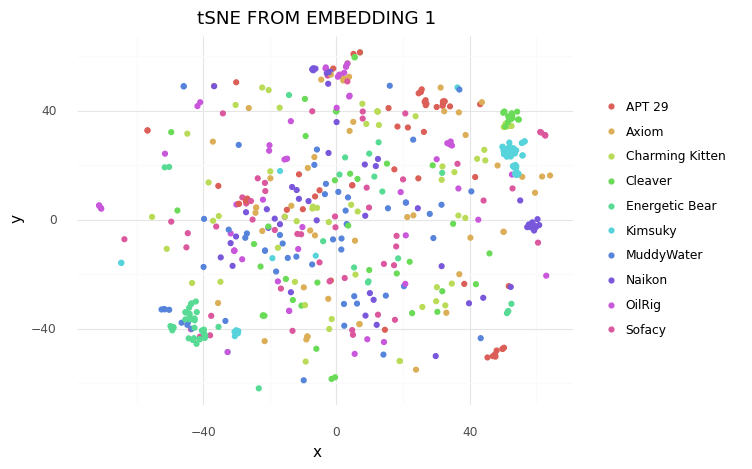

<ggplot: (8794353992455)>

In [10]:
gg_1 + labs(title="tSNE FROM EMBEDDING 1")

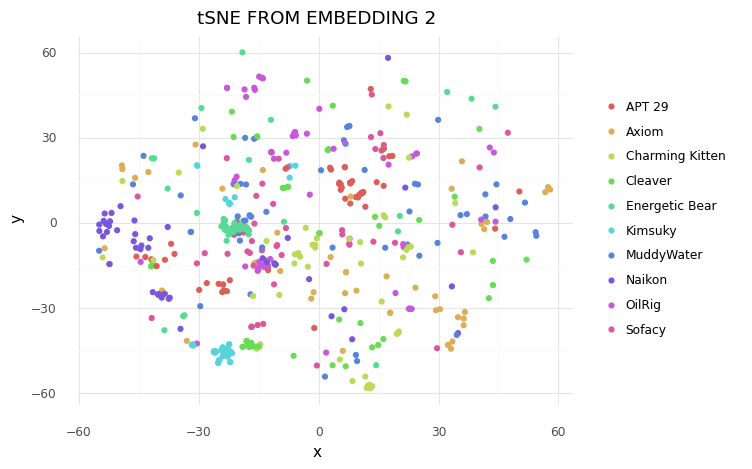

<ggplot: (8794356400192)>

In [11]:
gg_2 + labs(title="tSNE FROM EMBEDDING 2")

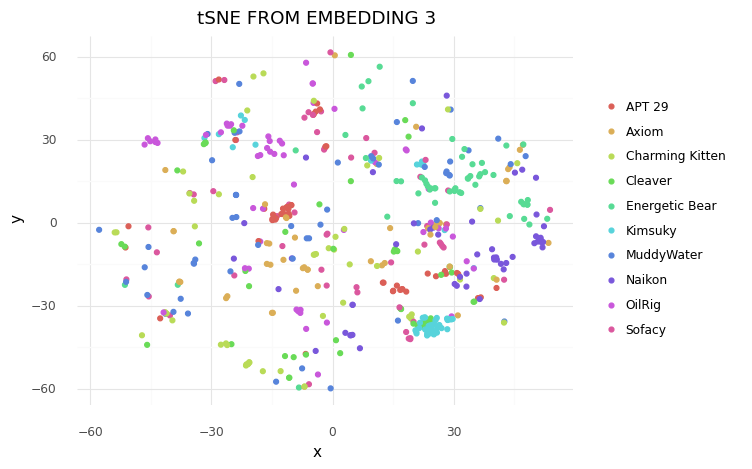

<ggplot: (8794338397130)>

In [12]:
gg_3 + labs(title="tSNE FROM EMBEDDING 3")

In [13]:
results_4 = (pd.concat([results_1, results_2, results_3])
               .groupby(["node_1", "node_2", "n1_actor", "n2_actor", "accurate"])
               .agg({"sim_score": np.median})
               .reset_index(drop=False)
               )

accuracy_intervals = [x/100 for x in range(99,1,-1)]
accuracy_scores = []
observations = []
for interval in accuracy_intervals:
    temp = results_4[results_4["sim_score"]>interval]
    if len(temp) > 0:
        temp_accuracy = sum(temp.accurate)/len(temp)
        accuracy_scores.append(temp_accuracy) 
        observations.append(len(temp))
    else:
        pass
        accuracy_scores.append(0) 
        observations.append(0)

performance_df_4 = pd.DataFrame({"threshold": accuracy_intervals,
                            "accuracy": accuracy_scores,
                            "n": observations})

performance_df = pd.concat(
        [performance_df_1.assign(model="DeepWalk"),
        performance_df_2.assign(model="Walklets"),
        performance_df_3.assign(model="Role2Vec"),
        performance_df_4.assign(model="Ensemble")
        ]
)

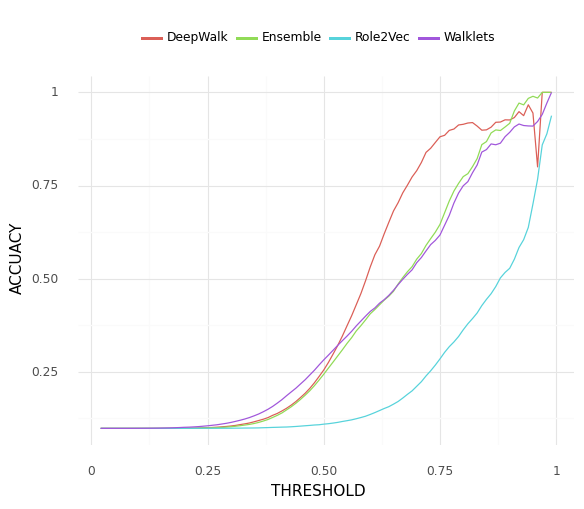

<ggplot: (8794224174294)>

In [14]:
gg = (ggplot() +
        geom_line(data=performance_df, mapping=aes(x="threshold", y="accuracy", color="model")) +
        labs(x="THRESHOLD", y="ACCUACY") +
        theme_minimal() +
        theme(legend_position="top",
              legend_title=element_blank())
        )
gg

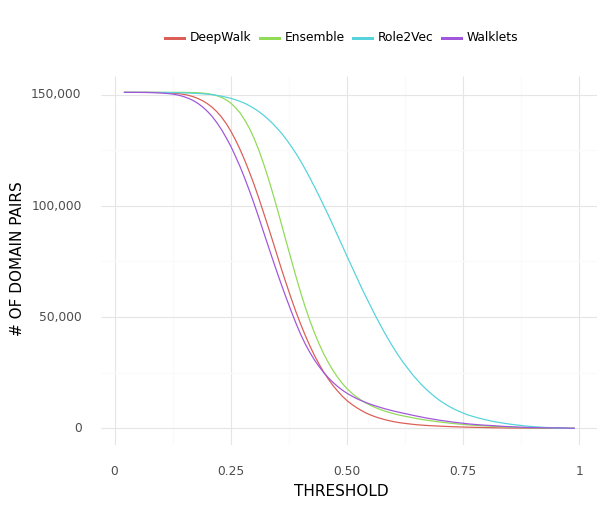

<ggplot: (8794340949227)>

In [15]:
gg = (ggplot() +
        geom_line(data=performance_df, mapping=aes(x="threshold", y="n", color="model")) +
        labs(x="THRESHOLD", y="# OF DOMAIN PAIRS") +
        theme_minimal() +
        scale_y_continuous(labels=comma_format()) +
        theme(legend_position="top",
              legend_title=element_blank())
        )
gg

In [16]:
# output accuracy metrics so we can put specific numbers to what is displayed in the above plots
def accuracy_over_threshold(results, threshold):
    temp = results.query("sim_score > {}".format(threshold))
    return sum(temp.accurate)/len(temp)

thresholds = [0.97, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5]
results = [results_1, results_2, results_3, results_4]
for threshold in thresholds:
    print("==={}===".format(threshold))
    for i, result in enumerate(results):
        print("model_{} accuracy:\t {:.03%} on n = {} @ threshold {}"
        .format(i+1, accuracy_over_threshold(result, threshold), 
            len(result.query("sim_score > {}".format(threshold))), 
            threshold))

===0.97===
model_1 accuracy:	 100.000% on n = 1 @ threshold 0.97
model_2 accuracy:	 94.079% on n = 152 @ threshold 0.97
model_3 accuracy:	 85.897% on n = 78 @ threshold 0.97
model_4 accuracy:	 100.000% on n = 39 @ threshold 0.97
===0.95===
model_1 accuracy:	 94.444% on n = 18 @ threshold 0.95
model_2 accuracy:	 90.952% on n = 210 @ threshold 0.95
model_3 accuracy:	 70.051% on n = 197 @ threshold 0.95
model_4 accuracy:	 98.947% on n = 95 @ threshold 0.95
===0.9===
model_1 accuracy:	 92.593% on n = 81 @ threshold 0.9
model_2 accuracy:	 89.275% on n = 345 @ threshold 0.9
model_3 accuracy:	 52.789% on n = 771 @ threshold 0.9
model_4 accuracy:	 91.703% on n = 229 @ threshold 0.9
===0.8===
model_1 accuracy:	 91.429% on n = 350 @ threshold 0.8
model_2 accuracy:	 74.928% on n = 1384 @ threshold 0.8
model_3 accuracy:	 36.277% on n = 3771 @ threshold 0.8
model_4 accuracy:	 77.392% on n = 1066 @ threshold 0.8
===0.7===
model_1 accuracy:	 78.995% on n = 995 @ threshold 0.7
model_2 accuracy:	 54.29